<a href="https://colab.research.google.com/github/leobonn1/devai/blob/main/brazilian_court_decisions_tf_idf_vectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset('joelniklaus/brazilian_court_decisions')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels= dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')



Train size: 3234 -- 3234
Test size: 405 -- 405


In [4]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [7]:
!python -m spacy download pt_core_news_sm

import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

train_texts = preprocess_texts(train_texts)

test_texts = preprocess_texts(test_texts)

2023-12-11 21:08:10.665853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 21:08:10.665920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 21:08:10.665970: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 21:08:10.679490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 21:08:13.017962: W tensorflow/compiler/

Preprocessing: 100%|██████████| 405/405 [00:08<00:00, 47.65it/s]


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#vectorizer_option = 'binary'
#vectorizer_option = 'count'
vectorizer_option = 'tf_idf'

vectorizer = None

if vectorizer_option == 'binary':
  vectorizer = CountVectorizer(binary=True, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'count':
  vectorizer = CountVectorizer(binary=False, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'tf_idf':
  vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=None)

print(f'Vectorizer Option: {vectorizer_option}')

Vectorizer Option: tf_idf


In [9]:
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

print(f'\nExample Raw Text: {train_texts[0]}')
print(f'\nExample Vectorized Text: {X_train[0]}')
print(f'Vocabulary: {len(vectorizer.vocabulary_)}')


Example Raw Text: direito penal processual penal revisão criminal artigo 621 código processo penal requerente condenado júri popular prática crimes homicídio duplamente qualificado homicídio qualificado tentado pleito refazimento dosimetria pena imposta requerente admissibilidade via revisional precedentes alegação erro processo dosimetria pena comportamento vítima circunstância judicial neutra considerada desfavorável sentenciando precedentes superior tribunal justiça entendimento câmara criminal tribunal justiça afastamento culpabilidade ausência exposição motivos incremento pena-base afastado desvalor valoração atribuída circunstâncias crime mantida fundamentação idônea pena-base reduzida compensação agravante motivação torpe atenuante confissão espontânea pena privativa liberdade redimensionada crime tentado aplicada fração redutora máxima ante distância atos praticados requerente consumação crime pena redimensionada

Example Vectorized Text: [0. 0. 0. ... 0. 0. 0.]
Vocabulary: 12

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
import lightgbm as ltb
from sklearn.neural_network import MLPClassifier
from sklearn import svm

classifiers = {
    'Logistic_Regression': LogisticRegression(class_weight='balanced',
                                             max_iter=1000),
    'Multinomial_NB': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random_Forest': RandomForestClassifier(),
    'Decision_Tree' : DecisionTreeClassifier(),
    'Extra_Tree' : ExtraTreesClassifier(),
    'Cat_Boost' : CatBoostClassifier(iterations=1000),
    'Light_GBM' : ltb.LGBMClassifier(),
    'MLP' :  MLPClassifier(random_state=1, max_iter=300),
    'SVM' : svm.SVC()
}

***********************************************

Classifier: Logistic_Regression
              precision    recall  f1-score     support
0              0.843902  0.739316  0.788155  234.000000
1              0.560345  0.698925  0.622010   93.000000
2              0.583333  0.628205  0.604938   78.000000
accuracy       0.708642  0.708642  0.708642    0.708642
macro avg      0.662527  0.688815  0.671701  405.000000
weighted avg   0.728606  0.708642  0.714717  405.000000


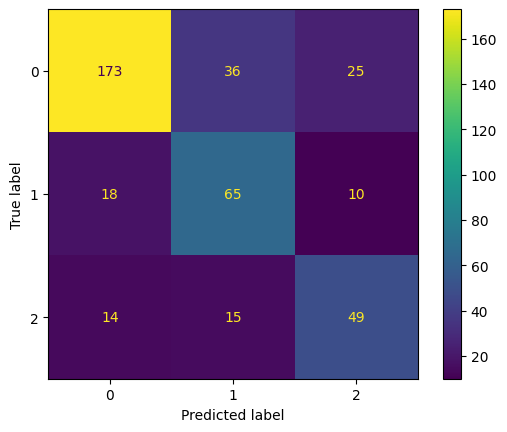

***********************************************

Classifier: Multinomial_NB


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score     support
0              0.604775  0.974359  0.746318  234.000000
1              0.750000  0.225806  0.347107   93.000000
2              0.000000  0.000000  0.000000   78.000000
accuracy       0.614815  0.614815  0.614815    0.614815
macro avg      0.451592  0.400055  0.364475  405.000000
weighted avg   0.521648  0.614815  0.510912  405.000000


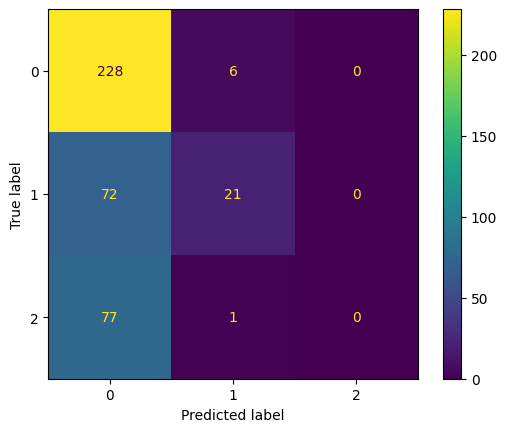

***********************************************

Classifier: KNN


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score     support
0              1.000000  0.004274  0.008511  234.000000
1              0.230198  1.000000  0.374245   93.000000
2              0.000000  0.000000  0.000000   78.000000
accuracy       0.232099  0.232099  0.232099    0.232099
macro avg      0.410066  0.334758  0.127585  405.000000
weighted avg   0.630638  0.232099  0.090855  405.000000


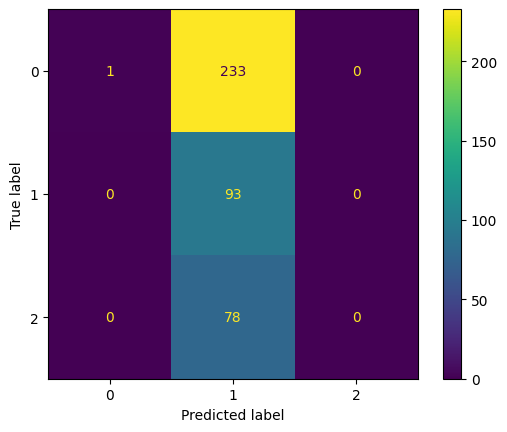

***********************************************

Classifier: Random_Forest
              precision    recall  f1-score     support
0              0.709779  0.961538  0.816697  234.000000
1              0.745098  0.408602  0.527778   93.000000
2              0.837838  0.397436  0.539130   78.000000
accuracy       0.725926  0.725926  0.725926    0.725926
macro avg      0.764238  0.589192  0.627868  405.000000
weighted avg   0.742553  0.725926  0.696895  405.000000


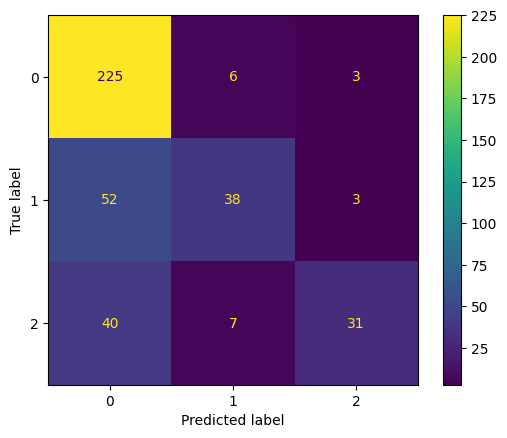

***********************************************

Classifier: Decision_Tree
              precision    recall  f1-score     support
0              0.766129  0.811966  0.788382  234.000000
1              0.585106  0.591398  0.588235   93.000000
2              0.587302  0.474359  0.524823   78.000000
accuracy       0.696296  0.696296  0.696296    0.696296
macro avg      0.646179  0.625908  0.633813  405.000000
weighted avg   0.690120  0.696296  0.691663  405.000000


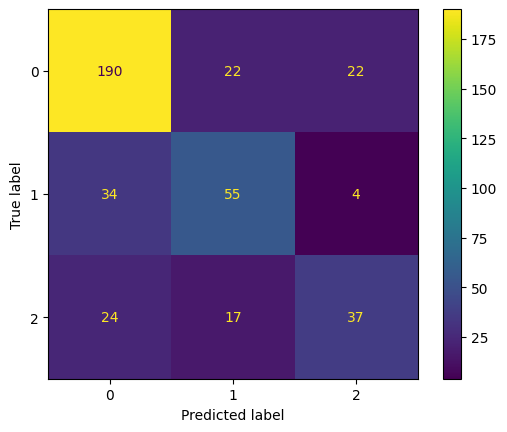

***********************************************

Classifier: Extra_Tree
              precision    recall  f1-score     support
0              0.694190  0.970085  0.809269  234.000000
1              0.812500  0.419355  0.553191   93.000000
2              0.833333  0.320513  0.462963   78.000000
accuracy       0.718519  0.718519  0.718519    0.718519
macro avg      0.780008  0.569984  0.608475  405.000000
weighted avg   0.748155  0.718519  0.683770  405.000000


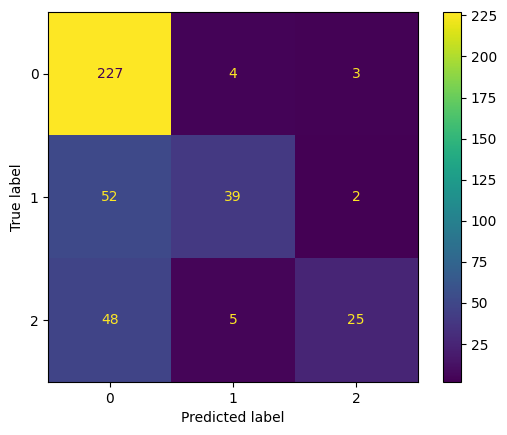

***********************************************

Classifier: Cat_Boost
Learning rate set to 0.084008
0:	learn: 1.0563033	total: 730ms	remaining: 12m 9s
1:	learn: 1.0273439	total: 1.4s	remaining: 11m 40s
2:	learn: 0.9979081	total: 2.06s	remaining: 11m 24s
3:	learn: 0.9660025	total: 2.7s	remaining: 11m 12s
4:	learn: 0.9376876	total: 3.36s	remaining: 11m 9s
5:	learn: 0.9165085	total: 4.28s	remaining: 11m 48s
6:	learn: 0.8956686	total: 5.35s	remaining: 12m 39s
7:	learn: 0.8813927	total: 7.09s	remaining: 14m 39s
8:	learn: 0.8660262	total: 8.16s	remaining: 14m 59s
9:	learn: 0.8547150	total: 8.85s	remaining: 14m 36s
10:	learn: 0.8417977	total: 9.51s	remaining: 14m 15s
11:	learn: 0.8323290	total: 10.2s	remaining: 13m 56s
12:	learn: 0.8231031	total: 10.8s	remaining: 13m 41s
13:	learn: 0.8163051	total: 11.5s	remaining: 13m 28s
14:	learn: 0.8050131	total: 12.1s	remaining: 13m 17s
15:	learn: 0.7990442	total: 12.8s	remaining: 13m 6s
16:	learn: 0.7916456	total: 13.5s	remaining: 12m 58s
17:	learn: 0.

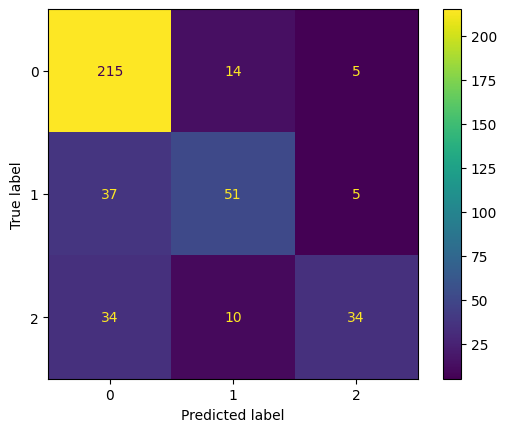

***********************************************

Classifier: Light_GBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52021
[LightGBM] [Info] Number of data points in the train set: 3234, number of used features: 1742
[LightGBM] [Info] Start training from score -0.500775
[LightGBM] [Info] Start training from score -1.563804
[LightGBM] [Info] Start training from score -1.689558
              precision    recall  f1-score     support
0              0.811321  0.918803  0.861723  234.000000
1              0.683544  0.580645  0.627907   93.000000
2              0.770492  0.602564  0.676259   78.000000
accuracy       0.780247  0.780247  0.780247    0.780247
macro avg      0.755119  0.700671  0.721963  405.000000
weighted avg   0.774116  0.780247  0.772313  405.000000


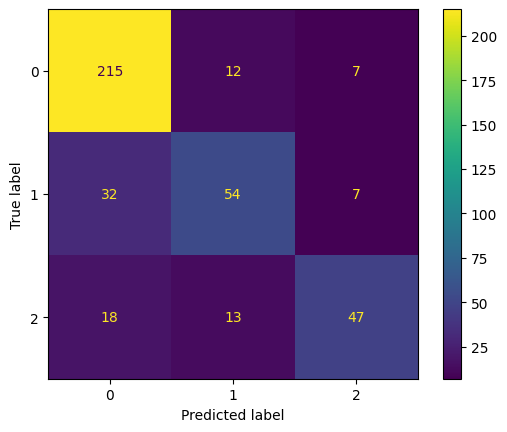

***********************************************

Classifier: MLP
              precision    recall  f1-score     support
0              0.792969  0.867521  0.828571  234.000000
1              0.638298  0.645161  0.641711   93.000000
2              0.618182  0.435897  0.511278   78.000000
accuracy       0.733333  0.733333  0.733333    0.733333
macro avg      0.683149  0.649527  0.660520  405.000000
weighted avg   0.723789  0.733333  0.724554  405.000000


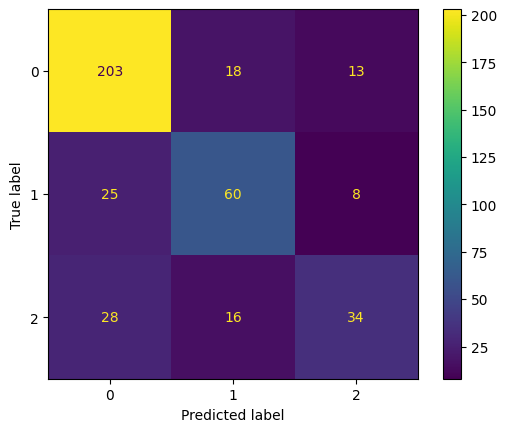

***********************************************

Classifier: SVM


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

for classifier_name, classifier in classifiers.items():
  print('***********************************************')
  print(f'\nClassifier: {classifier_name}')

  classifier.fit(X_train, train_labels)

  y_pred = classifier.predict(X_test)

  report = classification_report(test_labels, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  df.to_csv(f'{vectorizer_option}_{classifier_name}.csv')
  print(df)

  ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

  plt.show()
